In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import matplotlib.gridspec as gridspec
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
    device = torch.device("cuda")  # Select GPU device
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")   # Fall back to CPU

CUDA is available. Training on GPU.


In [48]:
BATCH_SIZE = 64
# Load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])

# Load MNIST dataset
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                            download=True, transform=transform)

minst_train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=True,transform=transformer)
minst_test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                            download=True,transform=transformer)


total_size = len(minst_train_dataset)
train_size = int(total_size * 0.7)  # 70% of the dataset for training
valid_size = total_size - train_size


mnist_train_set_cnn, mnist_valid_set_cnn = random_split(minst_train_dataset, [train_size, valid_size])
mnist_train_loader_cnn = torch.utils.data.DataLoader(mnist_train_set_cnn, batch_size=BATCH_SIZE, shuffle=True)
mnist_valid_loader_cnn = torch.utils.data.DataLoader(mnist_valid_set_cnn, batch_size=BATCH_SIZE, shuffle=True)
mnist_test_loader_cnn = torch.utils.data.DataLoader(minst_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


total_size = len(mnist_trainset)
train_size = int(total_size * 0.7)  # 70% of the dataset for training
valid_size = total_size - train_size


mnist_train_set, mnist_valid_set = random_split(mnist_trainset, [train_size, valid_size])
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=BATCH_SIZE, shuffle=True)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid_set, batch_size=BATCH_SIZE, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
class Discriminator(nn.Module):
    def __init__(self,h_dim,X_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        self.apply(self.init_weights)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            #nn.init.xavier_normal_(m.weight.data)
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)
            
    def forward(self, x):
        #x = x.view(x.size(0), -1)
        return self.model(x)

class Generator(nn.Module):
    def __init__(self,Z_dim,h_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 784),
            nn.Tanh()
        )
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            #nn.init.xavier_normal_(m.weight.data)
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)
            
    def forward(self, z):
        return self.model(z)

    
# Conditional GAN models    
class CDiscriminator(nn.Module):
    
    def __init__(self,num_classes,h_dim,X_dim):
        super(CDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(X_dim + num_classes, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            
    def forward(self, x,y):
        c = self.label_emb(y)
        inputs = torch.cat([x, c], dim=1)
        return self.model(inputs)

class CGenerator(nn.Module):
    
    def __init__(self,num_classes,Z_dim,h_dim):
        super(CGenerator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(Z_dim + num_classes, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 784),
            nn.Tanh()
        )
        
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            
    def forward(self, z,y):
        c = self.label_emb(y)
        inputs = torch.cat([z, c], dim=1)
        return self.model(inputs)

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def train(epochs, train_set, mb_size, Z_dim, G, D, d_optimizer, g_optimizer, criterion, device, g_name, d_name, ones_label, zeros_label):
    for epoch in range(epochs):
        
        z = torch.randn(mb_size, Z_dim).to(device)
        X, _ = train_set.data[torch.randint(len(train_set), (mb_size,))].view(-1, 784).float().div(255), train_set.targets[torch.randint(len(train_set), (mb_size,))]
        X = X.to(device)
        # Train Discriminator
        D_real = D(X)
        D_fake = D(G(z))

        D_loss = -torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))

        D.zero_grad()
        
        D_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(mb_size, Z_dim).to(device)

        G_loss = -torch.mean(torch.log(D(G(z)) + 1e-8))

        G.zero_grad()
        
        G_loss.backward()
        g_optimizer.step()

        if (epoch+1) % 10000 == 0:
            print('Epoch-{}; D_loss: {:.4f}; G_loss: {:.4f}'.format(epoch+1, D_loss.item(), G_loss.item()))

            samples = G(z).data.cpu().detach().numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    # Save models
    torch.save(G.state_dict(), g_name)
    torch.save(D.state_dict(), d_name)

    
def train_con(epochs, train_set, mb_size, Z_dim, G, D, d_optimizer, g_optimizer, criterion, device, g_name, d_name, ones_label, zeros_label):
    for epoch in range(epochs):
        
        z = torch.randn(mb_size, Z_dim).to(device)
        idx = torch.randint(len(train_set), (mb_size,))
        X, y = train_set.data[idx].view(-1, 784).float().div(255).to(device), train_set.targets[idx].to(device)
        # Train Discriminator
        D_real = D(X, y)
        D_fake = D(G(z, y), y)

        D_loss = -torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))

        D.zero_grad()        
        D_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(mb_size, Z_dim).to(device)

        G_loss = -torch.mean(torch.log(D(G(z, y), y) + 1e-8))

        G.zero_grad()       
        G_loss.backward()
        g_optimizer.step()

        if (epoch+1) % 10000 == 0:
            print('Epoch-{}; D_loss: {:.4f}; G_loss: {:.4f}'.format(epoch+1, D_loss.item(), G_loss.item()))

            samples = G(z, y).data.cpu().detach().numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    torch.save(G.state_dict(), g_name)
    torch.save(D.state_dict(), d_name)



In [7]:
def test_model(Z_dim, G, D, g_name, d_name, device,num_samples=16):
    G.load_state_dict(torch.load(g_name))
    G.eval()

    # Generate fake samples
    with torch.no_grad():
        z = torch.randn(Z_dim, 100).to(device)
        fake_images = G(z)

    fig = plt.figure(figsize=(4, 4))
    for i in range(num_samples):
        ax = fig.add_subplot(4, 4, i + 1)
        ax.imshow(fake_images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

In [13]:
learning_rate = 0.001
mb_size = 64
Z_dim=100
h_dim = 128
X_dim = minst_train_dataset[0][0].shape[1] * minst_train_dataset[0][0].shape[2]

ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)

g_name_st_10000 = 'generator.pth'
d_name_st_10000 = 'discriminator.pth'

G_10000 = Generator(h_dim=h_dim,Z_dim=Z_dim).to(device)
D_10000 = Discriminator(h_dim=h_dim,X_dim=X_dim).to(device)

# Optimizers
d_optimizer = optim.Adam(D_10000.parameters(), lr=learning_rate, weight_decay=1e-5)
g_optimizer = optim.Adam(G_10000.parameters(), lr=learning_rate, weight_decay=1e-5)

# Loss function
criterion = nn.BCELoss()

Epoch-10000; D_loss: 0.3465; G_loss: 3.2400
Epoch-20000; D_loss: 0.6076; G_loss: 3.9593
Epoch-30000; D_loss: 0.6336; G_loss: 3.0738
Epoch-40000; D_loss: 1.0932; G_loss: 1.1396
Epoch-50000; D_loss: 1.3919; G_loss: 0.6923
Epoch-60000; D_loss: 1.0480; G_loss: 1.7569
Epoch-70000; D_loss: 0.8189; G_loss: 2.3047
Epoch-80000; D_loss: 1.1919; G_loss: 0.9068
Epoch-90000; D_loss: 1.0288; G_loss: 1.4635
Epoch-100000; D_loss: 1.1833; G_loss: 0.7757


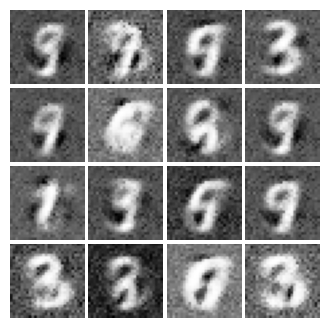

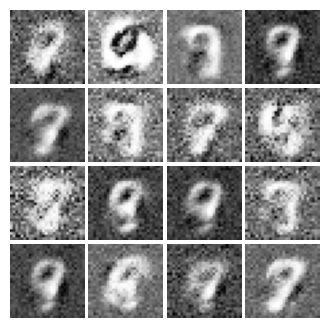

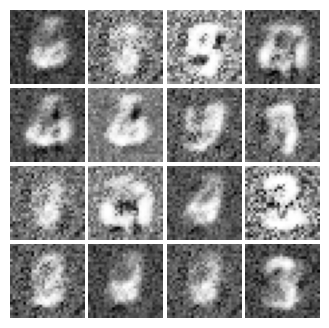

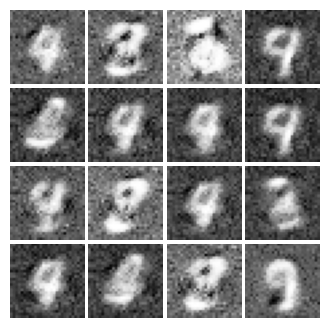

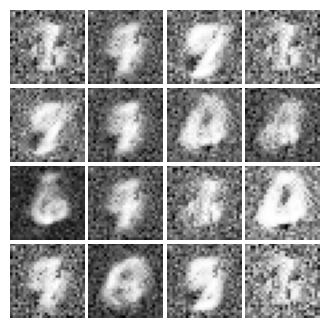

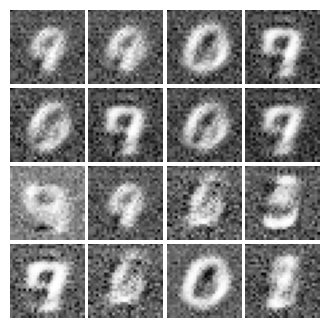

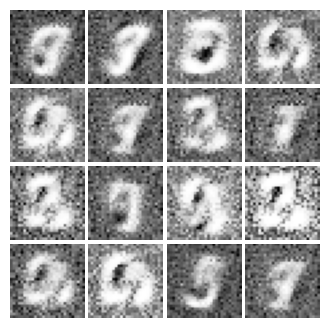

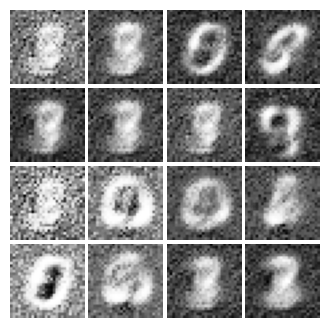

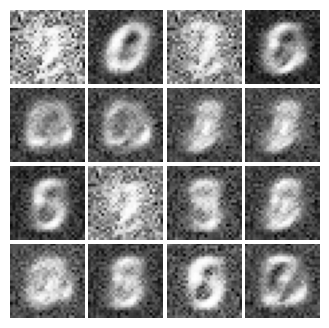

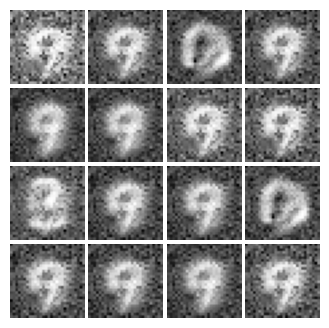

In [14]:
train(epochs=100000, train_set=minst_train_dataset, mb_size=mb_size, Z_dim=Z_dim, G=G_10000, D=D_10000,
      d_optimizer=d_optimizer, g_optimizer=g_optimizer, criterion=criterion, device=device, g_name=g_name_st_10000,
      d_name=d_name_st_10000,ones_label=ones_label,zeros_label=zeros_label)

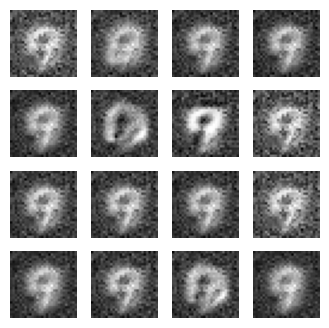

In [15]:
test_model(G=G_10000, D=D_10000,g_name=g_name_st_10000,d_name=d_name_st_10000,device=device,Z_dim=Z_dim)

In [16]:
learning_rate = 0.001
mb_size = 64
Z_dim=100
h_dim = 128
X_dim = minst_train_dataset[0][0].shape[1] * minst_train_dataset[0][0].shape[2]

ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)
g_name_bce = 'generator_bce_2000.pth'
d_name_bce = 'discriminator_bce_2000.pth'

G_BCE = Generator(h_dim=h_dim,Z_dim=Z_dim).to(device)
D_BCE = Discriminator(h_dim=h_dim,X_dim=X_dim).to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
d_optimizer = optim.Adam(D_BCE.parameters(), lr=learning_rate, weight_decay=1e-5)
g_optimizer = optim.Adam(G_BCE.parameters(), lr=learning_rate, weight_decay=1e-5)

Epoch-10000; D_loss: 0.4394; G_loss: 4.4813
Epoch-20000; D_loss: 0.5013; G_loss: 3.7495


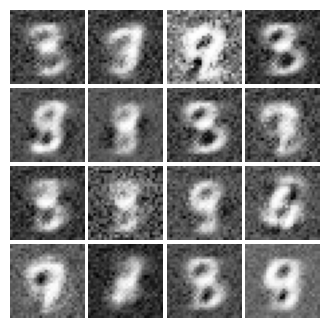

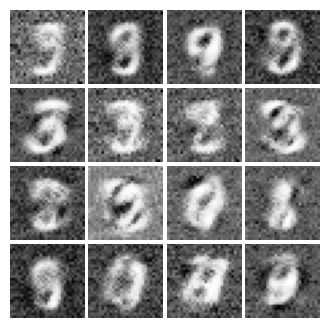

In [17]:
train(epochs=20000, train_set=minst_train_dataset, mb_size=mb_size, Z_dim=Z_dim, G=G_BCE, D=D_BCE,
      d_optimizer=d_optimizer, g_optimizer=g_optimizer, criterion=criterion, device=device, g_name=g_name_bce,
      d_name=d_name_bce,ones_label=ones_label,zeros_label=zeros_label)

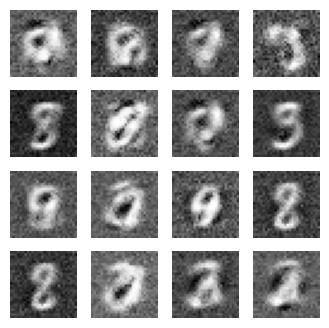

In [18]:
test_model(G=G_BCE, D=D_BCE,g_name=g_name_bce,d_name=d_name_bce,device=device,Z_dim=Z_dim)

In [19]:
learning_rate = 0.001
mb_size = 64
Z_dim=100
h_dim = 128
X_dim = minst_train_dataset[0][0].shape[1] * minst_train_dataset[0][0].shape[2]

ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)
g_name_bce_100000 = 'generator_bce_100000.pth'
d_name_bce_100000 = 'discriminator_bce_100000.pth'

G_BCE_100 = Generator(h_dim=h_dim,Z_dim=Z_dim).to(device)
D_BCE_100 = Discriminator(h_dim=h_dim,X_dim=X_dim).to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
d_optimizer = optim.Adam(D_BCE_100.parameters(), lr=learning_rate, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G_BCE_100.parameters(), lr=learning_rate, betas=(0.5, 0.999))

Epoch-10000; D_loss: 0.9480; G_loss: 1.2721
Epoch-20000; D_loss: 0.9056; G_loss: 2.0678
Epoch-30000; D_loss: 0.6433; G_loss: 2.5404
Epoch-40000; D_loss: 0.4448; G_loss: 2.8866
Epoch-50000; D_loss: 0.3769; G_loss: 3.2012
Epoch-60000; D_loss: 0.3226; G_loss: 3.8822
Epoch-70000; D_loss: 0.1772; G_loss: 4.1290
Epoch-80000; D_loss: 0.1640; G_loss: 4.8442
Epoch-90000; D_loss: 0.1139; G_loss: 4.7543
Epoch-100000; D_loss: 0.0951; G_loss: 5.8224


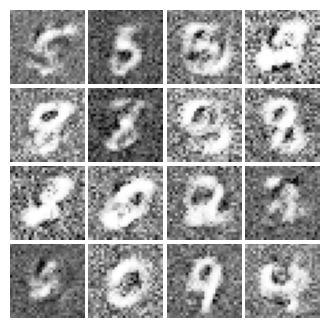

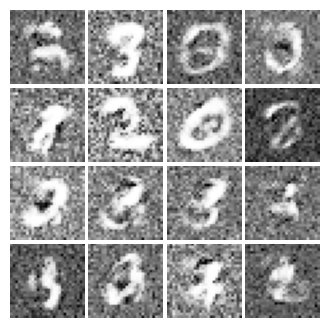

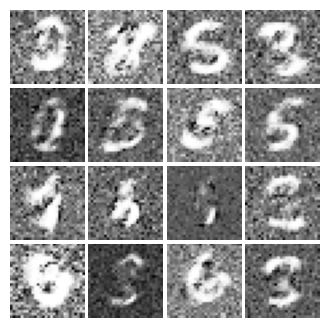

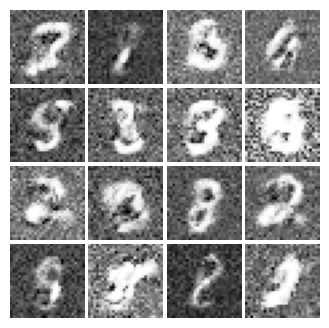

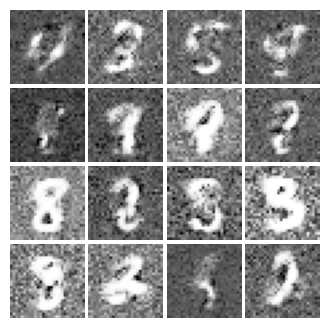

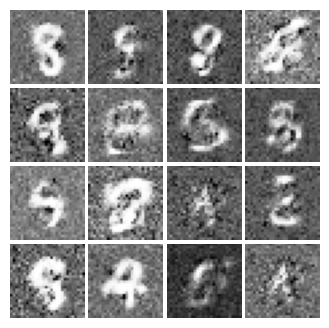

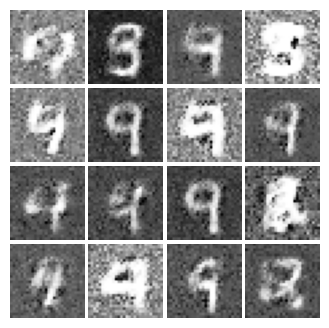

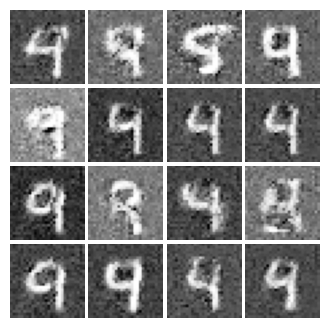

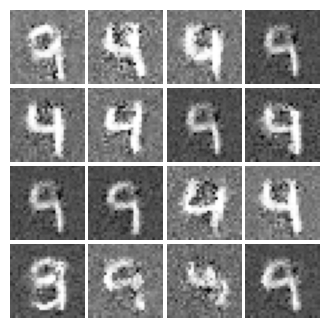

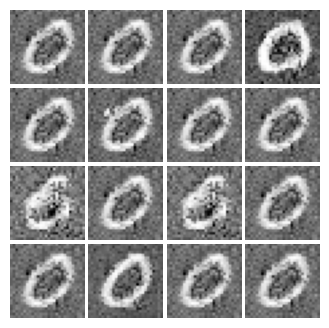

In [20]:
train(epochs=100000, train_set=minst_train_dataset, mb_size=mb_size, Z_dim=Z_dim, G=G_BCE_100, D=D_BCE_100,
      d_optimizer=d_optimizer, g_optimizer=g_optimizer, criterion=criterion, device=device, g_name=g_name_bce_100000,
      d_name=d_name_bce_100000,ones_label=ones_label,zeros_label=zeros_label)

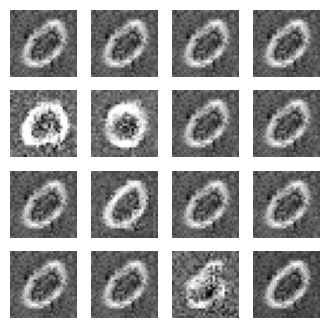

In [21]:
test_model(G=G_BCE_100, D=D_BCE_100,g_name=g_name_bce_100000,d_name=d_name_bce_100000,device=device,Z_dim=Z_dim)

In [33]:
# Conditional GAN
learning_rate = 0.0001
mb_size = 64
Z_dim=100
h_dim = 128
X_dim = minst_train_dataset[0][0].shape[1] * minst_train_dataset[0][0].shape[2]
num_classes  = len(minst_train_dataset.classes)

ones_label = torch.ones(mb_size, 1).to(device)
zeros_label = torch.zeros(mb_size, 1).to(device)

g_name_con_10000 = 'con_generator.pth'
d_name_con_10000 = 'con_discriminator.pth'

G_con_10000 = CGenerator(num_classes=num_classes,Z_dim=Z_dim,h_dim=h_dim).to(device)
D_con_10000 = CDiscriminator(num_classes=num_classes,X_dim=X_dim,h_dim=h_dim).to(device)

# Optimizers
d_optimizer = optim.Adam(D_con_10000.parameters(), lr=learning_rate, weight_decay=1e-5)
g_optimizer = optim.Adam(G_con_10000.parameters(), lr=learning_rate, weight_decay=1e-5)

# Loss function
criterion = nn.BCELoss()

Epoch-10000; D_loss: 0.2594; G_loss: 2.4560
Epoch-20000; D_loss: 0.5908; G_loss: 1.9548
Epoch-30000; D_loss: 0.7529; G_loss: 2.0589
Epoch-40000; D_loss: 1.0958; G_loss: 1.5231
Epoch-50000; D_loss: 1.0402; G_loss: 1.3751
Epoch-60000; D_loss: 0.9594; G_loss: 1.3674
Epoch-70000; D_loss: 1.0211; G_loss: 1.4059
Epoch-80000; D_loss: 1.1148; G_loss: 1.5793
Epoch-90000; D_loss: 1.2700; G_loss: 1.2727
Epoch-100000; D_loss: 1.0383; G_loss: 1.3276


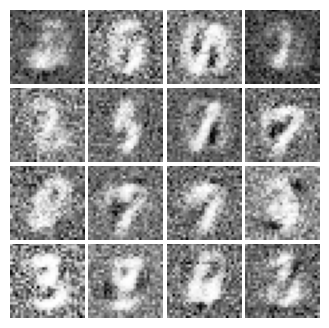

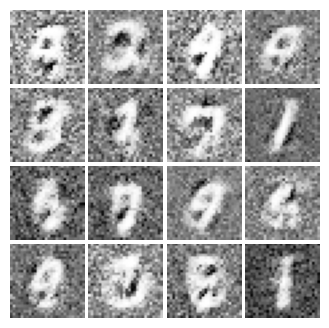

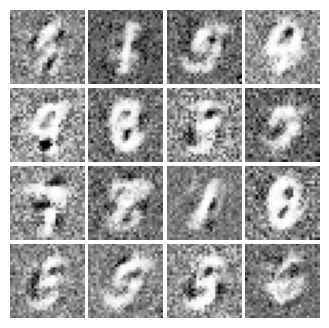

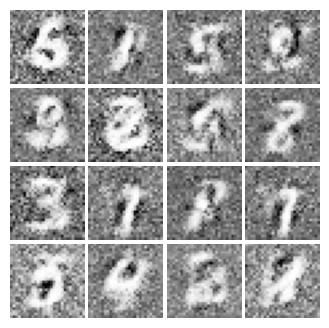

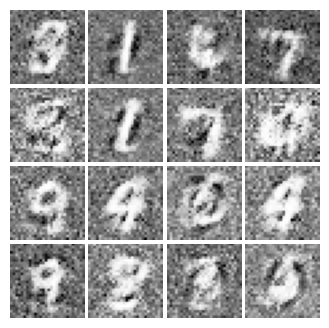

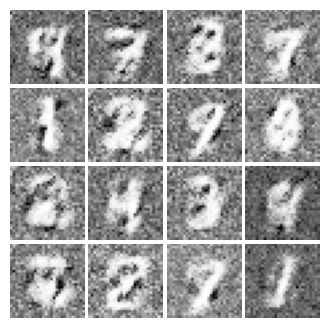

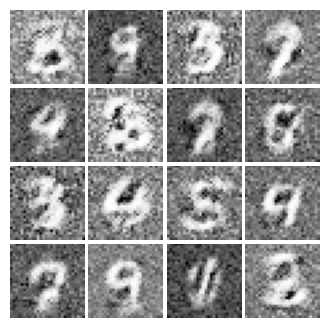

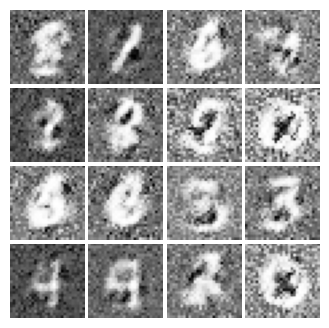

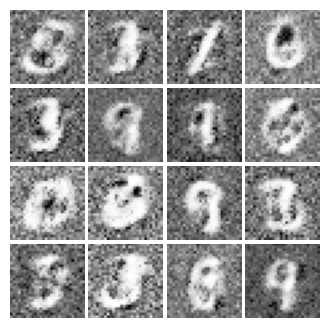

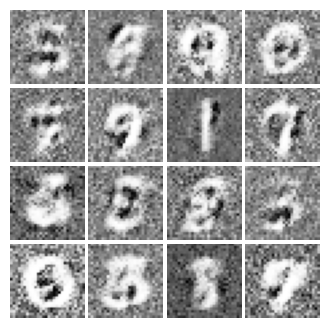

In [34]:
train_con(epochs=100000, train_set=minst_train_dataset, mb_size=mb_size, Z_dim=Z_dim, G=G_con_10000, D=D_con_10000,
      d_optimizer=d_optimizer, g_optimizer=g_optimizer, criterion=criterion, device=device, g_name=g_name_con_10000,
      d_name=d_name_con_10000,ones_label=ones_label,zeros_label=zeros_label)

The number to generate: 2


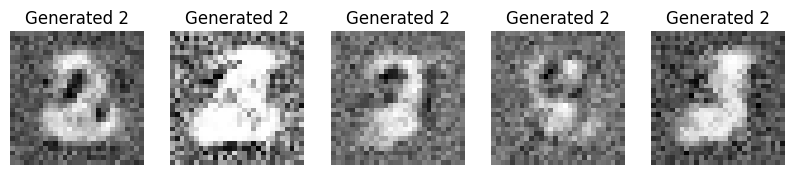

The number to generate: 3


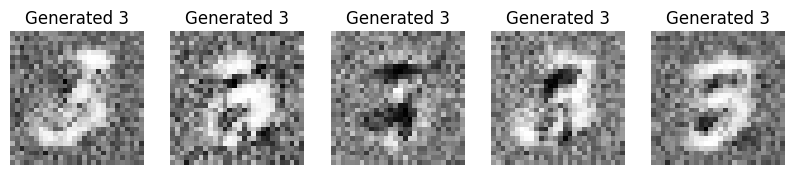

The number to generate: 5


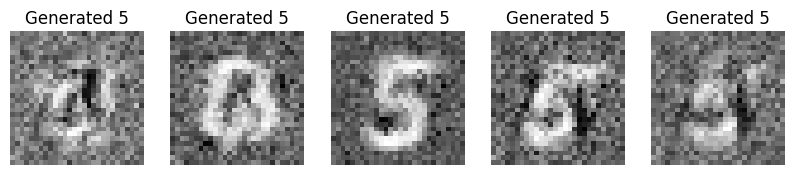

The number to generate: 8


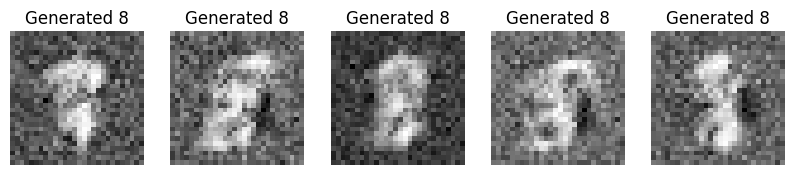

In [36]:
num_classes  = len(minst_train_dataset.classes)
generator = CGenerator(num_classes=num_classes,Z_dim=Z_dim,h_dim=h_dim).to(device)
generator.load_state_dict(torch.load(g_name_con_10000))
generator.eval()

# Generate sample images for a specific label
num_samples_per_label = 5
label_of_interest_list = [2,3,5,8] # Choose any number between 0-9

for label_of_interest in label_of_interest_list:
    print(f"The number to generate: {label_of_interest}")
    sample_labels = torch.tensor([label_of_interest] * num_samples_per_label).to(device)
    sample_z = torch.randn(num_samples_per_label, Z_dim).to(device)
    sample_images = generator(sample_z, sample_labels).detach().cpu().numpy()

    # Plot sample images
    fig, axes = plt.subplots(nrows=1, ncols=num_samples_per_label, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Generated {label_of_interest}')
    plt.show()

In [69]:
# Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [70]:
model_cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
cnn_model_name =  'cnn.pth'
num_epochs = 50

In [39]:
# train model
def train(model,model_name, optimizer, criterion, train_loader, valid_loader, num_epochs,device):
    global writer
    train_loss_list = []
    valid_loss_list = []
    best_val_loss = np.inf
    best_model_sd = None
    model.to(device)
    for epoch in range(num_epochs):
        train_loss = 0
        valid_loss = 0

        model.train()

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader)

        model.eval()

        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

        valid_loss = valid_loss / len(valid_loader)

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_model_sd = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_sd)

    plt.plot(range(1,num_epochs + 1), train_loss_list)
    plt.plot(range(1,num_epochs + 1), valid_loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training loss")

    torch.save(model.state_dict(), model_name)

In [40]:
def test_model(model, model_name, test_loader,device):
    model.load_state_dict(torch.load(model_name))
    classes = ['0', '1', '2', '3',
               '4', '5', '6', '7', '8', '9']
    
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.to(device)
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test accuracy of the network: {100 * correct // total} %')
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Epoch 10/50, Training Loss: 0.5976, Validation Loss: 3.9331
Epoch 20/50, Training Loss: 0.3339, Validation Loss: 3.9696
Epoch 30/50, Training Loss: 0.2557, Validation Loss: 4.5061
Epoch 40/50, Training Loss: 0.0001, Validation Loss: 4.3522
Epoch 50/50, Training Loss: 0.0000, Validation Loss: 5.0437


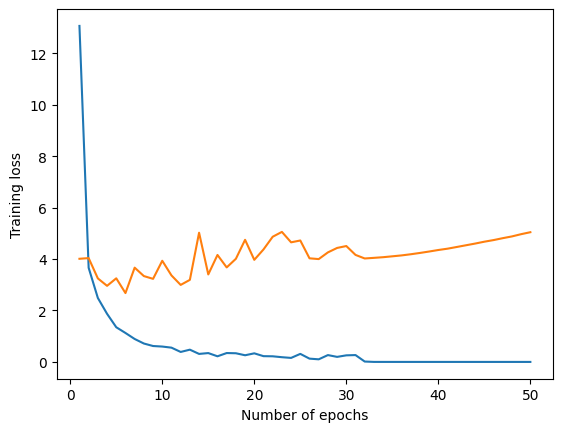

In [50]:
train(model_cnn,cnn_model_name,optimizer, criterion, mnist_train_loader_cnn,mnist_valid_loader_cnn, num_epochs, device)

Test accuracy of the network: 99 %


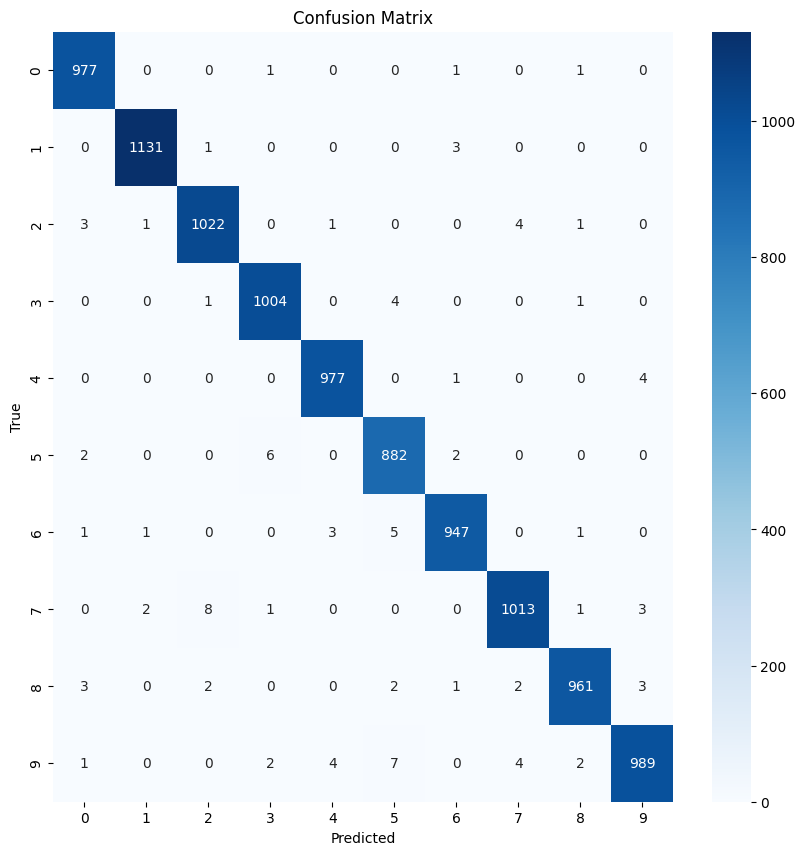

In [52]:
test_model(model_cnn,cnn_model_name,mnist_test_loader_cnn, device)

In [125]:
from mpl_toolkits.axes_grid1 import ImageGrid

def generate_plot_adversarial_images(image, label, model,cnn_model_name,device, lr=0.1, n_steps=5, epsilon=0.1, output_probs=False):
    model.load_state_dict(torch.load(cnn_model_name))
    model.to(device)
    model.eval()
    original_image = image.clone().detach()
    probs_per_step = []
    image = image.float().to(device)
    for _ in range(n_steps):
        image.requires_grad = True
        model.zero_grad()
        # Forward pass to get the output probabilities
        output = model(image)
        
        # Calculate loss
        loss = F.cross_entropy(output, label)
        
        # Backpropagate to compute gradients
        
        loss.backward()
        
        # Generate adversarial image
        with torch.no_grad():
            image_grad = image.grad.data
            image_adv = image - lr * image_grad.sign()
            image_adv = torch.clamp(image_adv, 0, 1)
        
        # Plot images and return probabilities
        img_adv_list = torch.cat((original_image, image_grad, image_adv), dim=0)
        probs = plot_predictions(img_adv_list, model, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None
        
        # Update image for next iteration
        image = image_adv.clone().detach()
    
    return probs_per_step

def plot_predictions(image_list, model, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    with torch.no_grad():
        prob = F.softmax(model(image_list), dim=1)
    
    pred_list = torch.argmax(prob, dim=1)
    pct_list = torch.max(prob, dim=1).values * 100
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0] / cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(image_list.shape[0]):
        image = image_list[i].squeeze().cpu().numpy()
        grid[i].imshow(image, cmap='gray')
        
        if adversarial and i % 3 == 1:
            grid[i].set_title("Adversarial \nPartial Derivatives")
        else:
            grid[i].set_title('Label: {0} \nCertainty: {1:.2f}%' \
                          .format(pred_list[i].item(), pct_list[i].item()))
    
    plt.show()
    
    return prob.cpu().numpy() if output_probs else None

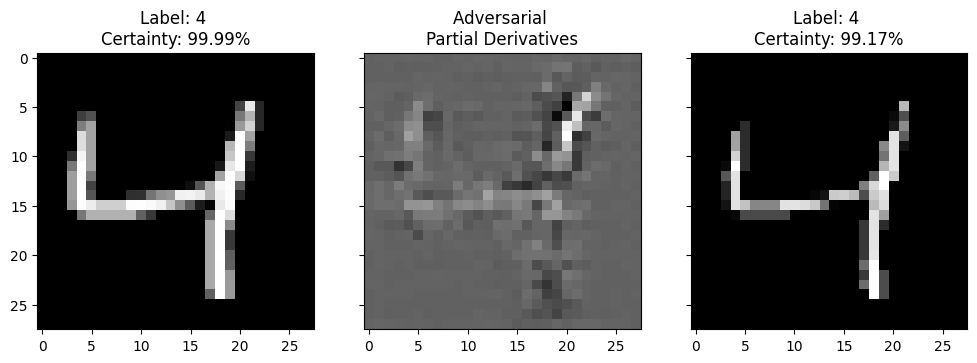

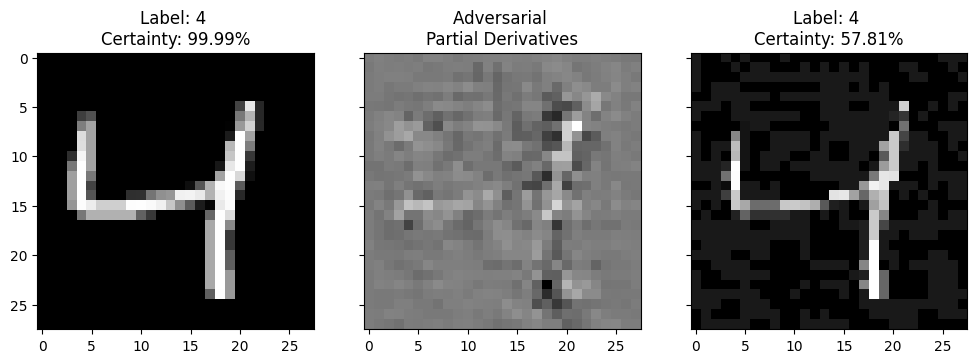

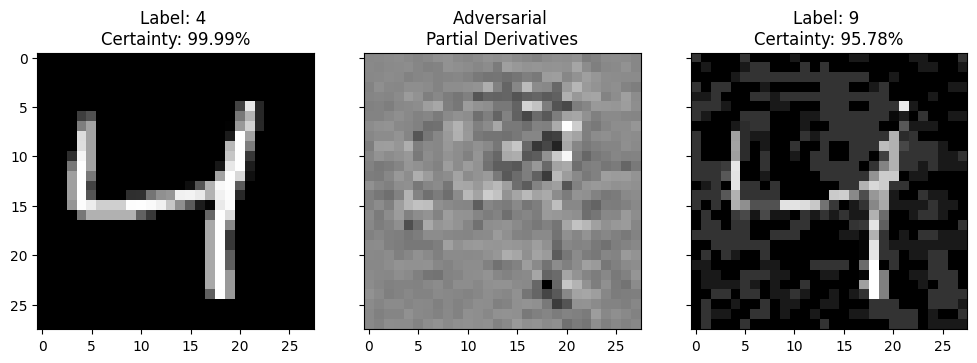

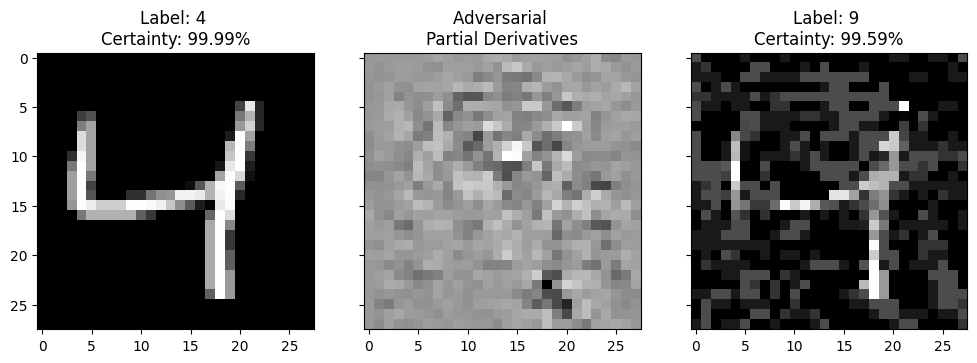

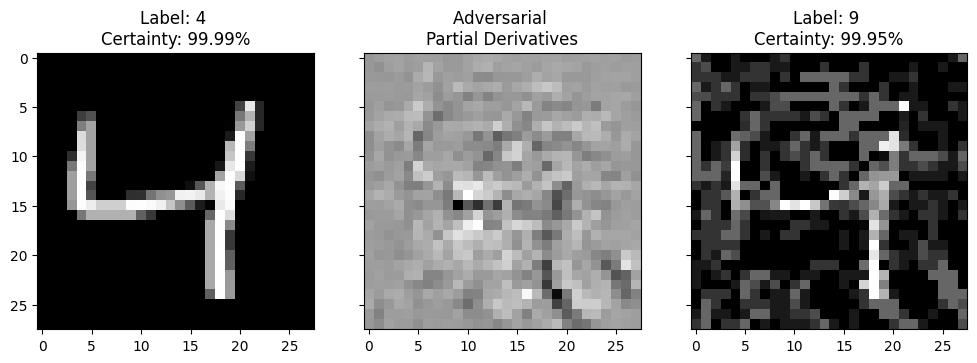

[]

In [126]:
for image, label in minst_train_dataset:
    if label == 4:
        # Convert the image to the desired format and move it to the device
        sample_image = image.unsqueeze(0).to(device)
        break
generate_plot_adversarial_images(sample_image, torch.tensor([9]).to(device), model_cnn,cnn_model_name,device)

In [128]:
#Experiment
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.    
        
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()
        
        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = x.view(b, c, -1).permute(0, 2, 1)

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = x.permute(0, 2, 1).view(b, c, h, w)

        # Residue connection
        return x + x_in
    
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x    

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim

        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        
        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                   If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs    


# Define U-Net noise predictor
class UNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=2048,
                 text_dim=2048, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor.
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h3 = F.interpolate(h3, size=h.shape[2:], mode='nearest')
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h2 = F.interpolate(h2, size=h.shape[2:], mode='nearest')
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h1 = F.interpolate(h1, size=h.shape[2:], mode='nearest')
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [101]:
def train_diffusion_model(model,model_name, device, num_epochs, train_loader,valid_loader, optimizer):

    model.to(device)
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = 0
        num_items = 0
        for i, data in enumerate(train_loader, 0):
            inputs, y = data
            inputs = inputs.to(device)
            y = y.to(device)
            
            loss = loss_fn_cond(model, inputs, y,marginal_prob_std)
            optimizer.zero_grad()
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            train_loss += loss.item()* inputs.shape[0]
            num_items += inputs.shape[0]

        if valid_loader is not None:
            valid_loss = 0
            valid_items = 0
            
            with torch.no_grad():
                for data in valid_loader:
                    inputs, y = data
                    inputs = inputs.to(device)
                    y = y.to(device)
                    loss = loss_fn_cond(model, inputs, y, marginal_prob_std)
                    valid_loss += loss.item() * inputs.shape[0]
                    valid_items += inputs.shape[0]
            
            # Calculate average validation loss
            avg_valid_loss = valid_loss / valid_items
            
            # Save the model if the validation loss is improved
            if avg_valid_loss < best_valid_loss:
                best_valid_loss = avg_valid_loss
                torch.save(model.state_dict(), model_name)

    
        # Print loss every few steps
        if (epoch+1) % 10 == 0:
            print('Epoch: {} Average Training Loss: {:5f}, Validation Loss: {:5f}'.format(epoch+1, train_loss / num_items, avg_valid_loss))
            
    #torch.save(model.state_dict(), model_name)

# Define the marginal_prob_std function
def marginal_prob_std(t, sigma=25):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)
    
    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    
    # Resize z to match the spatial dimensions of score * std[:, None, None, None]
    z_resized = F.interpolate(z, size=(score.size(2), score.size(3)), mode='nearest')
    
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z_resized)**2, dim=(1, 2, 3)))
    return loss

In [129]:
import torch.nn.functional as F
import math

unet = torch.nn.DataParallel(UNet(marginal_prob_std))

model_name_new = 'newconf.pth'
optimizer = optim.Adam(unet.parameters(), lr=0.001)
num_epochs = 150


train_diffusion_model(model=unet,model_name=model_name_new, device=device, num_epochs=num_epochs, train_loader=mnist_train_loader,valid_loader=mnist_valid_loader, optimizer=optimizer)

/tmp/ipykernel_33/2803407798.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Epoch: 10 Average Training Loss: 72.074073, Validation Loss: 177.533360
Epoch: 20 Average Training Loss: 78.360576, Validation Loss: 76.676034
Epoch: 30 Average Training Loss: 50.288278, Validation Loss: 47.904422
Epoch: 40 Average Training Loss: 47.438313, Validation Loss: 46.053980
Epoch: 50 Average Training Loss: 43.241326, Validation Loss: 45.096694
Epoch: 60 Average Training Loss: 42.613308, Validation Loss: 42.241662
Epoch: 70 Average Training Loss: 41.794993, Validation Loss: 41.594073
Epoch: 80 Average Training Loss: 42.544733, Validation Loss: 41.514811
Epoch: 90 Average Training Loss: 40.606721, Validation Loss: 40.611433
Epoch: 100 Average Training Loss: 40.307844, Validation Loss: 40.983916
Epoch: 110 Average Training Loss: 41.099042, Validation Loss: 40.453368
Epoch: 120 Average Training Loss: 40.088815, Validation Loss: 39.321772
Epoch: 130 Average Training Loss: 39.320744, Validation Loss: 43.138839
Epoch: 140 Average Training Loss: 38.888121, Validation Loss: 41.390721


In [130]:
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(1, 28, 28),
                           num_steps=500,
                           device='cuda',
                           eps=1e-3, y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    x = x.to(device)
    y = y.to(device)
    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    
    # Do not include any noise in the last sampling step.
    return mean_x

def diffusion_coeff(t, sigma=25):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)

/tmp/ipykernel_33/2803407798.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_33/2568922976.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


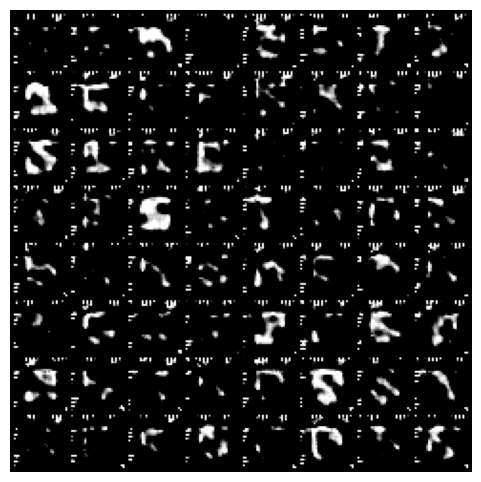

In [134]:
from tqdm.notebook import trange, tqdm
from torchvision.utils import make_grid
digit = 5 


unet.load_state_dict(torch.load(model_name_new))
unet.to(device)
unet.eval()

# Set the batch size for generating samples
sample_batch_size = 64 
num_steps = 250 


## Generate samples using the specified sampler.
samples = Euler_Maruyama_sampler(unet,
        marginal_prob_std,
        diffusion_coeff,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the generated samples
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()